In [155]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

In [156]:
!pip install opencv-contrib-python==3.4.2.17

In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
# file1 = open("temp.txt", "w+")
path1 = '/content/drive/MyDrive/class project/foreheadData/*_S1_*.jpg'
path2 = '/content/drive/MyDrive/class project/foreheadData/*_S2_*.jpg'
genuine = []
imposter = []
orb = cv2.ORB_create(400)
norm = cv2.NORM_HAMMING
bf = cv2.BFMatcher(norm)

for images in glob.glob(path1):
    
    identity1 = images.split('.jpg')[0].split('/')[-1].split('_')[0]
    img1 = cv2.imread(images)
    kp1, des1 = orb.detectAndCompute(img1,None)
    if len(kp1)>0:
        for image in glob.glob(path2):

            identity2 = image.split('.jpg')[0].split('/')[-1].split('_')[0]
            
            img2 = cv2.imread(image) # trainImage
            
            kp2, des2 = orb.detectAndCompute(img2,None)
            try:
                matches = bf.knnMatch(des1,des2, k=2)
                dis = bf.match(des1,des2)
                number_keypoints = 0
                if len(kp1) <= len(kp2):
                    number_keypoints = len(kp1)
                else:
                    number_keypoints = len(kp2)
                good = []
                for m,n in matches:
                    if m.distance < 0.7*n.distance:
                        good.append([m])

                score = len(good) / number_keypoints
                if identity1==identity2:
                    genuine.append(score)
                   
                else:
                    imposter.append(score)

                print(images + " " + image + " " + str(score)) # replace with 'cos' if using cosine similarity
            except:
                print(images + " " + image + " no key points found" )
# file1.close()
print(len(genuine))
print(len(imposter))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/class project/foreheadData/18_P2_S1_2.jpg /content/drive/MyDrive/class project/foreheadData/8_P1_S2_1.jpg 0.125
/content/drive/MyDrive/class project/foreheadData/18_P2_S1_2.jpg /content/drive/MyDrive/class project/foreheadData/8_P1_S2_2.jpg 0.0
/content/drive/MyDrive/class project/foreheadData/18_P2_S1_2.jpg /content/drive/MyDrive/class project/foreheadData/8_P1_S2_3.jpg 0.0
/content/drive/MyDrive/class project/foreheadData/18_P2_S1_2.jpg /content/drive/MyDrive/class project/foreheadData/8_P2_S2_1.jpg 0.0
/content/drive/MyDrive/class project/foreheadData/18_P2_S1_2.jpg /content/drive/MyDrive/class project/foreheadData/8_P2_S2_2.jpg 0.0
/content/drive/MyDrive/class project/foreheadData/18_P2_S1_2.jpg /content/drive/MyDrive/class project/foreheadData/8_P2_S2_3.jpg 0.1
/content/drive/MyDrive/class project/foreheadData/18_P2_S1_2.jpg /content/drive/MyDrive/class project/foreheadData/9_P1_S2_1.jpg 0.0
/content/drive/M

In [159]:
max(genuine)

2.5

In [160]:
max(imposter)

9.5

In [161]:
total_match_comparisons = len(genuine)+len(imposter)

In [162]:
def calculate_metric(threshold):
    correct_acceptance = list(filter(lambda x: x > threshold, genuine))
    correct_rejection =list(filter(lambda x: x < threshold, imposter))
    false_acceptance = list(filter(lambda x: x > threshold, imposter))
    false_rejection = list(filter(lambda x: x <= threshold, genuine))

    crr = (len(correct_acceptance)+len(correct_rejection)) / total_match_comparisons
    far = len(false_acceptance) / total_match_comparisons
    frr = len(false_rejection) / total_match_comparisons
    return crr, far, frr

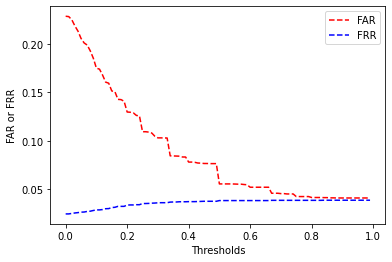

In [163]:
far_values = []
frr_values = []
crr_values = []
thresholds = []
# max_accuracy = 0
# thres = 0
for i in range(0, 100):
    crr, far, frr = calculate_metric(i*0.01)
    acc = 100-(far+frr)*100/2
    far_values.append(far)
    frr_values.append(frr)
    crr_values.append(crr)
    thresholds.append(i*0.01)
    
#     if max_accuracy <= acc:
#         max_accuracy = acc
#         thres = x*0.01
        
plt.plot(thresholds, far_values, 'r--' ,label='FAR')
plt.plot(thresholds, frr_values, 'b--' ,label = 'FRR')
plt.xlabel("Thresholds")
plt.ylabel("FAR or FRR")
plt.legend()
plt.show()
# print("Accuracy = ", max_accuracy)

In [164]:
far_values = [x*100 for x in far_values]

In [165]:
frr_values = [x*100 for x in frr_values]

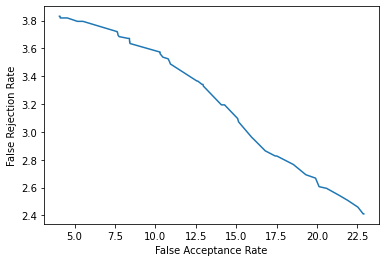

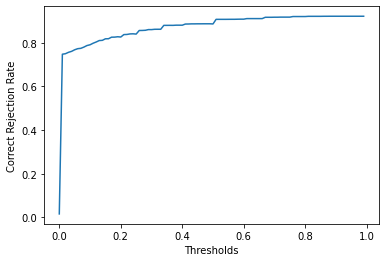

In [166]:
plt.plot(far_values, frr_values, label = 'False Rejection Rate vs False Acceptance Rate')
plt.xlabel('False Acceptance Rate')
plt.ylabel('False Rejection Rate')
plt.show()
plt.plot(thresholds, crr_values, label = 'Correct Rejection Rate vs Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Correct Rejection Rate')
plt.show()

In [167]:
genuine_rounded_score = [round(x, 2) for x in genuine]
imposter_rounded_score = [round(x, 2) for x in imposter]

In [168]:
(unique, counts) = np.unique(genuine_rounded_score, return_counts=True)
genuine_score_frequency = np.asarray((unique, counts)).T
(unique, counts) = np.unique(imposter_rounded_score, return_counts=True)
imposter_score_frequency = np.asarray((unique, counts)).T

In [169]:
for i in range(len(genuine_score_frequency)):
    genuine_score_frequency[i][1] = 100*genuine_score_frequency[i][1]/len(genuine)
for i in range(len(imposter_score_frequency)):
    imposter_score_frequency[i][1] = 100*imposter_score_frequency[i][1]/len(imposter)

In [170]:
genuine_values = [genuine_score_frequency[x][0] for x in range(len(genuine_score_frequency))]
genuine_prob = [genuine_score_frequency[x][1] for x in range(len(genuine_score_frequency))]
imposter_values = [imposter_score_frequency[x][0] for x in range(len(imposter_score_frequency))]
imposter_prob = [imposter_score_frequency[x][1] for x in range(len(imposter_score_frequency))]

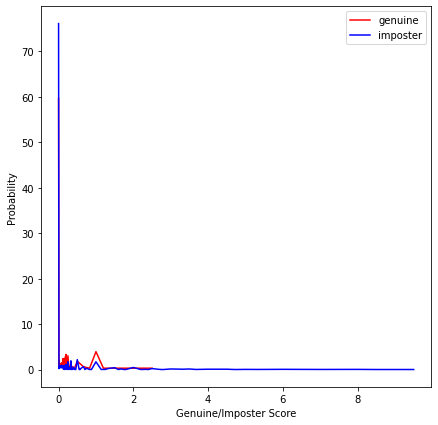

In [186]:
plt.figure(figsize= (7,7))
plt.plot(genuine_values, genuine_prob,'r' ,label='genuine')
plt.plot(imposter_values, imposter_prob, 'b' ,label='imposter')

plt.xlabel('Genuine/Imposter Score')
plt.ylabel('Probability')
plt.legend()
plt.show()

Text(0, 0.5, 'Probability %')

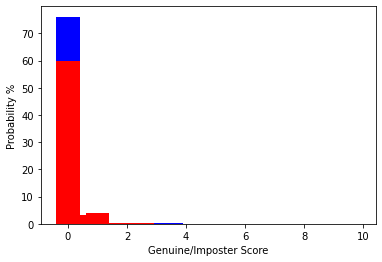

In [187]:
plt.bar(imposter_values, imposter_prob,align='center',color='b')
plt.bar(genuine_values,genuine_prob,align='center',color='r')

plt.xlabel('Genuine/Imposter Score')
plt.ylabel('Probability %')

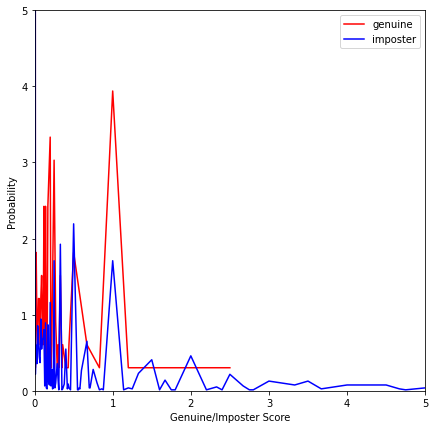

In [172]:
plt.figure(figsize= (7,7))
plt.plot(genuine_values, genuine_prob,'r' ,label='genuine')
plt.plot(imposter_values, imposter_prob, 'b' ,label='imposter')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('Genuine/Imposter Score')
plt.ylabel('Probability')
plt.legend()
plt.show()

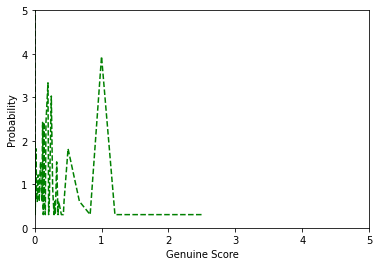

In [173]:
plt.plot(genuine_values, genuine_prob, 'g--')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Genuine Score')
plt.ylabel('Probability')
plt.show()

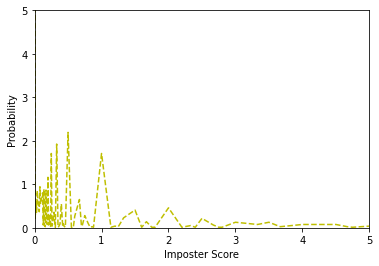

In [174]:
plt.plot(imposter_values, imposter_prob, 'y--')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Imposter Score')
plt.ylabel('Probability')
plt.show()

### EER and Threshold

In [175]:
min_diff = 100000
index = 0
for i in range(len(frr_values)):
    if abs(far_values[i]-frr_values[i])<=min_diff:
        min_diff = abs(far_values[i]-frr_values[i])
        index = i

In [176]:
thresholds[index] ## threshold

0.99

In [177]:
min_diff ## EER

0.23255813953488413

In [178]:
correct_acceptance = list(filter(lambda x: x > thresholds[index], genuine))
correct_rejection = list(filter(lambda x: x < thresholds[index], imposter))

false_acceptance = list(filter(lambda x: x > thresholds[index], imposter))
false_rejection = list(filter(lambda x: x <= thresholds[index], genuine))
crr = (len(correct_acceptance)+len(correct_rejection))/ total_match_comparisons
far = len(false_acceptance) / total_match_comparisons
frr = len(false_rejection) / total_match_comparisons

In [179]:
crr*100

92.10526315789474

In [180]:
far*100

4.063647490820074

In [181]:
frr*100

3.83108935128519

In [182]:
acc = 100-(far+frr)*100/2

In [183]:
acc ##accuracy

96.05263157894737